In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Standard error of autocorrelation


In [3]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`


In [4]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


### Plot of autocorrelation function

In [5]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


### Get linear regression coefficients ($b_0$ and $b_1$)

In [6]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


### Get ANOVA table

In [7]:
def get_ANOVA_table(df):
  [b0, b1], df_residual = get_regress_coeff(df)

  # calculation sum of squares total
  df_residual["meanY"] = df_residual['Y'].mean()
  df_residual["(Y - meanY)"] = df_residual['Y'] - df_residual["meanY"]
  df_residual["(Y - meanY)^2"] = df_residual['(Y - meanY)']**2

  # calculation sum of squares error
  df_residual['hat_Y'] = b0 + b1*df_residual['X']
  df_residual['(Y - hat_Y)'] = df_residual['Y'] - df_residual["hat_Y"]
  df_residual['(Y - hat_Y)^2'] = df_residual['(Y - hat_Y)']**2

  # calculation sum of squares regression
  df_residual['(hat_Y - meanY)^2'] = (df_residual['hat_Y'] - df_residual['meanY'])**2

  num_of_sample = len(df_residual)
  
  SST = df_residual["(Y - meanY)^2"].sum()
  SSE = df_residual["(Y - hat_Y)^2"].sum()
  SSR = df_residual["(hat_Y - meanY)^2"].sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([1, num_of_sample - 2, num_of_sample - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR / SST

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])
  
  print(f"Analyis of Variance")
  display(table_anova)


  return anova_table, df_residual, [SST, SSR, SSE] 

## Generate data

In [8]:
rng = np.random.default_rng(seed=2022_11_27)

l_bound = -2
u_bound = 2
N_samples = 100
Y_t = np.cumsum(l_bound + (u_bound-l_bound)*rng.random(99))
Y_t = np.hstack((0, Y_t))
Y_t = Y_t.reshape(-1, 1)

X_t = np.cumsum(l_bound + (u_bound-l_bound)*rng.random(99))
X_t = np.hstack((0, X_t))
X_t = X_t.reshape(-1, 1)

t = np.arange(100) + 1
t = t.reshape(-1, 1)
df = pd.DataFrame(
  np.hstack((t, Y_t, X_t)),
  columns=["t", "Y_t", "X_t"])

df


,t,Y_t,X_t
0,1.0,0.000000,0.000000
1,2.0,1.074268,-0.782873
2,3.0,1.815846,0.850507
3,4.0,0.192263,1.002626
4,5.0,-0.097986,-0.619154
...,...,...,...
95,96.0,11.844635,7.064908
96,97.0,13.187032,8.546443
97,98.0,12.504584,10.158234
98,99.0,12.092308,10.940892


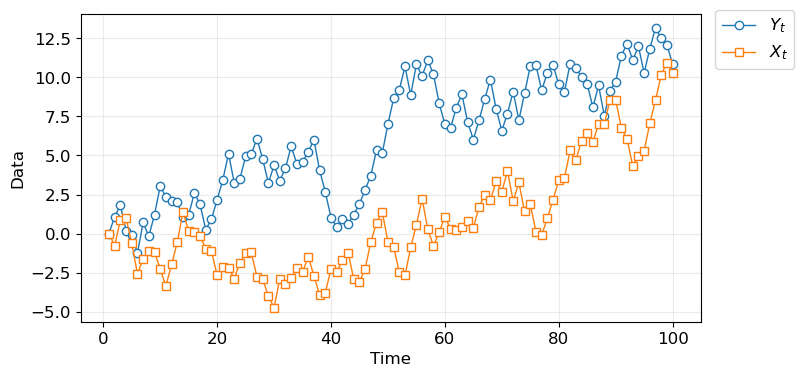

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df["t"], df["Y_t"], 'o', markerfacecolor="white", 
  linestyle='-', linewidth=1, label=r"$Y_t$")
ax.plot(df["t"], df["X_t"], 's', markerfacecolor="white", 
  linestyle='-', linewidth=1, label=r"$X_t$")

ax.set_xlabel("Time")
ax.set_ylabel("Data")
ax.grid("on")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])

plt.show(fig)

## Plot correlogram

### Time series $Y_t$

In [10]:
num_of_rk = 15 

df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "Y_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.930253,9.302532,89.159431,-0.198422,0.198422
1,2,0.866580,5.244069,167.320681,-0.327891,0.327891
2,3,0.814246,3.957751,237.037774,-0.408222,0.408222
3,4,0.759140,3.219860,298.268969,-0.467815,0.467815
4,5,0.707839,2.732331,352.064484,-0.514033,0.514033
5,6,0.641013,2.308056,396.651278,-0.551074,0.551074
6,7,0.582936,1.995335,433.921180,-0.579687,0.579687
7,8,0.524980,1.729424,464.477305,-0.602325,0.602325
8,9,0.483545,1.547319,490.685241,-0.620078,0.620078
9,10,0.459639,1.436821,514.628910,-0.634750,0.634750


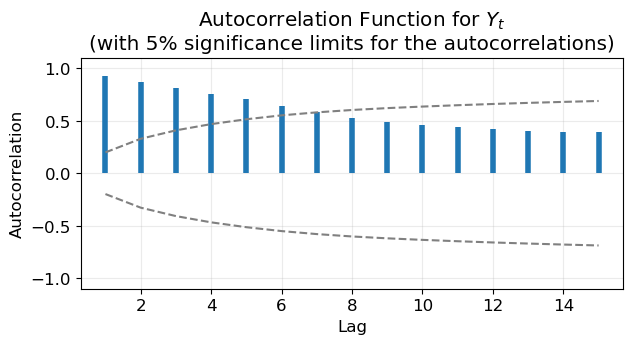

In [11]:
plot_autocorr_func(df_acorr_analysis, title=r"$Y_t$")


### Time series $X_t$

In [12]:
num_of_rk = 15 

df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "X_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.918756,9.187560,86.969184,-0.198422,0.198422
1,2,0.827839,5.049088,158.298099,-0.325328,0.325328
2,3,0.740822,3.677157,216.008843,-0.399752,0.399752
3,4,0.689537,3.036549,266.526614,-0.450574,0.450574
4,5,0.661804,2.677940,313.552366,-0.490363,0.490363
5,6,0.646087,2.444881,358.847758,-0.524351,0.524351
6,7,0.641901,2.295689,404.038838,-0.554809,0.554809
7,8,0.631627,2.148551,448.270545,-0.583316,0.583316
8,9,0.616637,2.006960,490.891026,-0.609650,0.609650
9,10,0.584698,1.830696,529.636456,-0.633730,0.633730


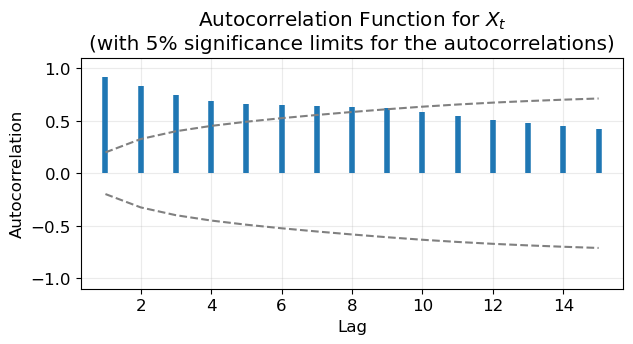

In [13]:
plot_autocorr_func(df_acorr_analysis, title=r"$X_t$")


## Fitted line plot (simple linear regression) 

In [83]:
df_fit = df.copy()

df_fit = df_fit.rename(columns=
  {"X_t": "X",
   "Y_t": "Y"})
df_fit

# compute fitted regression line
[b0, b1], _ = get_regress_coeff(df_fit)

# compute coefficient of determination
anova_table, _, [SST, SSR, SSE] = get_ANOVA_table(df_fit)
rSq = SSR/SST


Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,684.601,684.601,82.194,0.0000
Residual error,98,816.246,8.329,,
Total,99,1500.847,,,


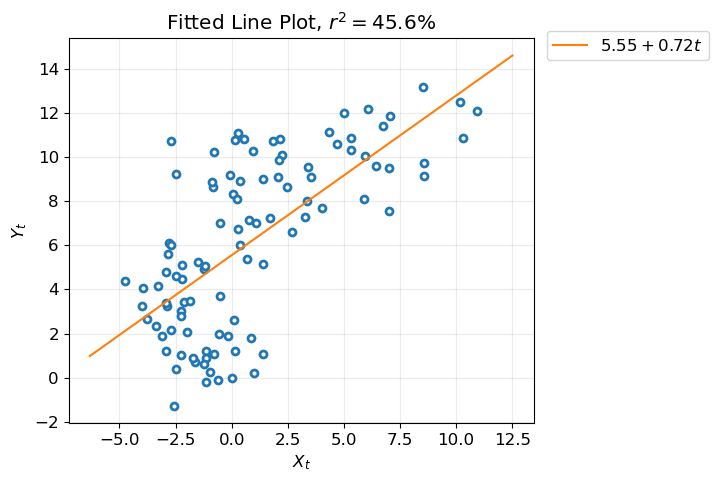

In [75]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

data_t_min = df_fit["X"].min()
data_t_max = df_fit["X"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$Y_t$")
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)



In [77]:
anova_table

Source,Sum of Squares,d.o.f,Mean Square
Regression,684.60,1,684.60
Error,816.25,98,8.33
Total,1500.85,99,
